##### On this jupyter notebook, we are continuing our project. We are using the previous data wrangling project we already made to proceed with the modeling part. 


##### The modeling part is about to predict how different stock prices (Apple, American Airlines, and Tesla) will move as function of the time and oil.


##### We will be doing two regression types. Standard Regression and Gradient Boosting Regressor. On this step, we are comparing standarized data and data without standarization.


##### After doing the regressions, we will be performing ARIMAX and SARIMAX analysis. We would be comparing the different models, the outcomes, computing errors, comparing with test data, and finally doing forecasting.


##### Finally, we are concluding what model is better if we want to predict stock prices, the advantages and disadvantages of the models, etc.

In [1]:
#Import libraries
import pandas as pd
from pandas_datareader.data import DataReader
import datetime
import functools
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import kpss
import sys
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

## Data Wrangling

I want to use a code that is reusable in case I want to add any other stock to our analysis.
I am using Data Reader to get the data from yahoo finance. This would give me the chance to get the data directly from the web without necessity of uploading any csv file.

After getting the data, I will convert the data to data frame to make the data easier to use.

In [2]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [3]:
#Define variables of data source, start and end date
start = datetime.date(2000,1,1)
end = datetime.date(2020,8,31)
source = 'yahoo'

In [4]:
#Get the data from the stocks we would like to make the data serie analysis
aapl = stock_data('AAPL', source, start, end)
aal = stock_data('AAL', source, start, end)
tsla = stock_data('TSLA', source, start, end)

I downloaded the oil data from quandl. We could also use Data Reader with an API key. To get the data we use the function the pandas function read_csv.

In [5]:
#Read the oil price
oil = pd.read_csv('OPEC-ORB.csv', index_col = 0)
oil.index = pd.to_datetime(oil.index)
oil.rename( columns = {'Value': 'Oil Price'}, inplace = True)

We also want to create a reusable code to merge different data frames. 

In [6]:
# Define a function to merge the different data frames
def merge_df(df1, df2, df3, df4):
    df = [df1, df2, df3, df4]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'inner', on = 'Date'), df)

In [7]:
#Data Frame we are going to make the times series
df = merge_df(oil, aapl, aal,tsla).sort_values(by = 'Date', ascending = True)

# Data Frame overview

#### I am exploring the data we have to see if it is necessary to drop/replace Null-Values.

In [8]:
#Info function on the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2559 entries, 2010-06-29 to 2020-08-31
Data columns (total 4 columns):
Oil Price    2559 non-null float64
AAPL         2559 non-null float64
AAL          2559 non-null float64
TSLA         2559 non-null float64
dtypes: float64(4)
memory usage: 100.0 KB


In [9]:
#Check if there is NaN values
df.isna().sum()

Oil Price    0
AAPL         0
AAL          0
TSLA         0
dtype: int64

In [10]:
# See the first 5 heads
df.head(n = 5)

,Oil Price,AAPL,AAL,TSLA
Date,,,,
2010-06-29,72.66,7.905947,8.051013,4.778
2010-06-30,72.49,7.762749,8.117004,4.766
2010-07-01,70.48,7.668618,8.154712,4.392
2010-07-02,69.63,7.621089,7.721052,3.840
2010-07-06,69.73,7.673245,7.617351,3.222


## Data Visualization

On this step I want to see the stock behavior during time. I am also doing correlation hetmaps to see how the stocks move in relation with the oil price. Additionally, I am plotting autocorrelation graphics to know the order of the ARIMA or SARIMAX model. Finally, I am doing a seasonal decompose to see trend, seasonality of the data I got.

### Plot the Multiple times series 

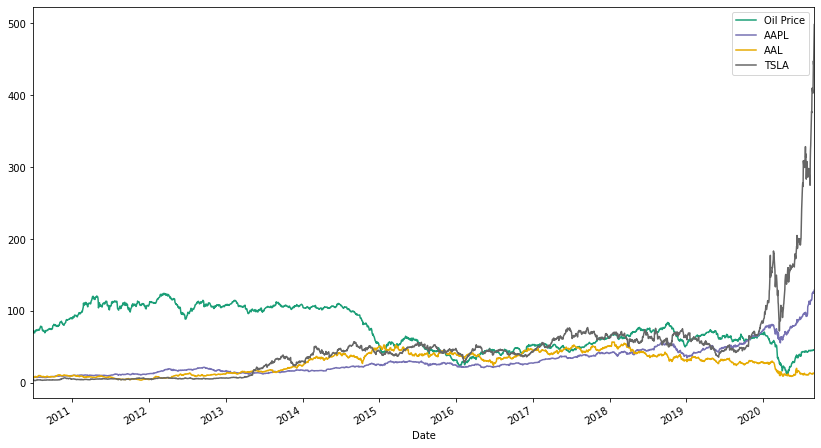

In [11]:
#Plot 
df.plot(cmap = 'Dark2', figsize = (14,8))
plt.legend(loc = 'best')
plt.show()

From the graphic above, we can see after 2019, Tesla stock dramatically increased its value over time. Right now, we could think Tesla stock would continue increasing the stock price for the momentum. Additionally, the oul price has fallen after 2015 (this because fracking was implemented and the majorist productors started competing with low price). For the correlation heatmap, we may use only the data available after 2019 to see the relation between oil and stock price recently and not being influenced by previous activities when oil price was really high and for example, Tesla stock was just on their beginning and the stock price was really low.

### Correlation among the stocks and the oil price

In [12]:
#Define the function to create the correlation matrix
def correlation_matrix(df, method):
    return df.corr(method = method)

In [13]:
#Define the function for the correlation heatmap
def correlation_matrix_heatmap(df, method):
    return sns.heatmap(df.corr(method = method))

#### Pearson Correlation

In [14]:
#Correlation Matrix
correlation_matrix(df, 'pearson')

,Oil Price,AAPL,AAL,TSLA
Oil Price,1.000000,-0.557381,-0.582359,-0.525530
AAPL,-0.557381,1.000000,0.254872,0.872993
AAL,-0.582359,0.254872,1.000000,0.202341
TSLA,-0.525530,0.872993,0.202341,1.000000


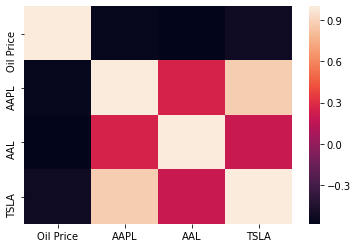

In [15]:
#Correlation heatmap
correlation_matrix_heatmap(df, 'pearson')

#### Kendall Correlation

In [16]:
#Correlation Matrix
correlation_matrix(df, 'kendall')

,Oil Price,AAPL,AAL,TSLA
Oil Price,1.000000,-0.339534,-0.392747,-0.397446
AAPL,-0.339534,1.000000,0.378958,0.714955
AAL,-0.392747,0.378958,1.000000,0.463211
TSLA,-0.397446,0.714955,0.463211,1.000000


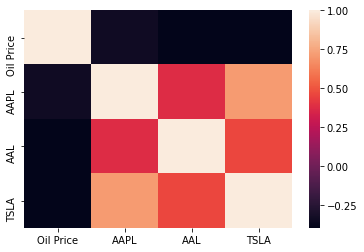

In [17]:
#Correlation Heatmap
correlation_matrix_heatmap(df, 'kendall')

#### Spearman Correlation

In [18]:
#Correlation Matrix
correlation_matrix(df, 'spearman')

,Oil Price,AAPL,AAL,TSLA
Oil Price,1.000000,-0.623095,-0.580366,-0.619377
AAPL,-0.623095,1.000000,0.553304,0.897840
AAL,-0.580366,0.553304,1.000000,0.626214
TSLA,-0.619377,0.897840,0.626214,1.000000


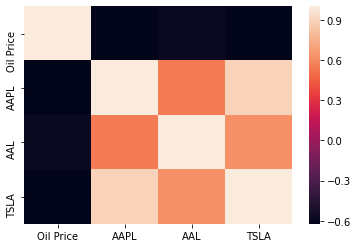

In [19]:
#Correlation Heatmap
correlation_matrix_heatmap(df, 'spearman')

#### Insights from the correlation matrix

- As expected, Tesla stock is the less correlated with the oil price and American Airlines the most correlated with the oil price.


- Regarding the correlation result for American Airlines, we have a following hypothesis: If there is an increase on the oil price is because the increase of the demand. People around the world are transportating, so there is more customers on the airline industry, so therefore an increase on its revenues. If the company does well, investors acquire stocks, and therefore stock price also increases.


- For Tesla we have the following hypothesis: Oil prices roses the lowest value in their history. Tesla on the other hand, they have their highest stock price. To remark, oil prices are down and Tesla stock prices are high, so that's why we can support their negative correlation.  Same can be explained with Apple. 


- In the future, we could have the following hypothesis to what is going to happen between Tesla and its stock price: Oil prices could continue going down due to the use of fraking. People may not see Tesla as savings to their budget since it would be cheaper to just continue using regular gas, thereby Tesla revenues would go down and therefore their stock price as well. On the other hand, people will to make the world more ecological can continue increasing Tesla revenues and therefore their stock price.

### Autocorrelation

In [20]:
stock_columns = list(df.columns)

In [21]:
#Define a data frame with the rate of return of the stocks and if the oil price increased, decreased or was the same
df_change = df.pct_change().dropna()

In [22]:
df_change.head(n = 5)

,Oil Price,AAPL,AAL,TSLA
Date,,,,
2010-06-30,-0.002340,-0.018113,0.008197,-0.002512
2010-07-01,-0.027728,-0.012126,0.004645,-0.078472
2010-07-02,-0.012060,-0.006198,-0.053179,-0.125683
2010-07-06,0.001436,0.006844,-0.013431,-0.160938
2010-07-07,0.000143,0.040382,0.153466,-0.019243


In [23]:
## Define a function that plots the autocorrelation
def plot_autocorrelation(x, lags, alpha):
    fig = plot_acf(x, lags = lags, alpha = alpha)
    return plt.show()

Oil Price


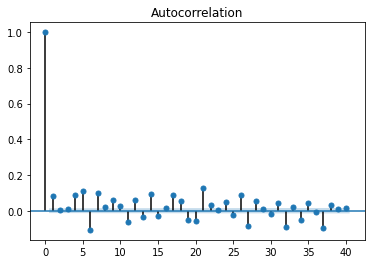

AAPL


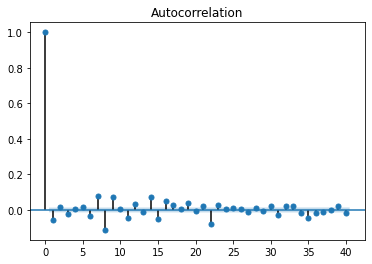

AAL


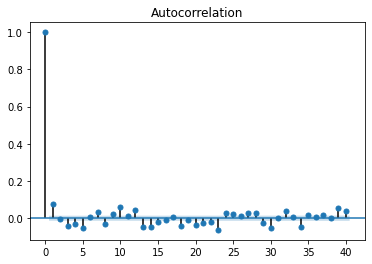

TSLA


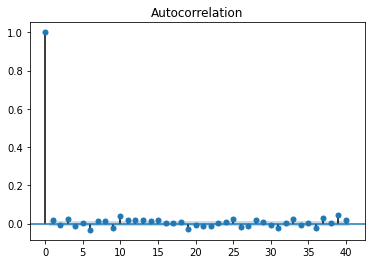

In [24]:
for col in stock_columns:
    print(col)
    plot_autocorrelation(df_change[col], lags = 40, alpha = 0.5)

#### Key Insights

- From the autocorrelation plots,we may conclude that all the stocks and also the oil price is order 1.

### Decomposition Analysis

In [25]:
def decomposition_analysis(x, model, freq):
    return seasonal_decompose(x = x , model = model , freq = freq)

In [26]:
#Apply the function for the columns
stocks_decompose = []
trends = []
seasonals = []
residuals = []
observeds = []

for stock in stock_columns:
    #Decomposition
    decomposition = decomposition_analysis(x = df[stock], model = 'multiplicative', freq = 252)
    stocks_decompose.append(decomposition)
    
    #Trend
    trend = decomposition.trend
    trends.append(trend)
    
    #Seasonal
    seasonal = decomposition.seasonal
    seasonals.append(seasonal)
    
    #Residual
    residual = decomposition.resid
    residuals.append(residual)
    
    #Observed
    observed = decomposition.observed
    observeds.append(observed)

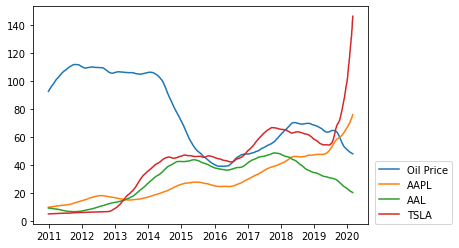

In [27]:
#Plot the trend for the stocks
for i, j in enumerate(stock_columns):
    plt.plot(trends[i], label = j)
    plt.legend(loc = (1.02, 0))
    continue

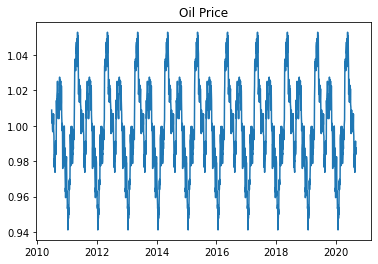

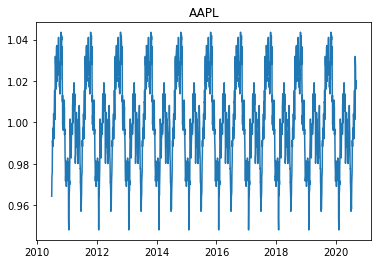

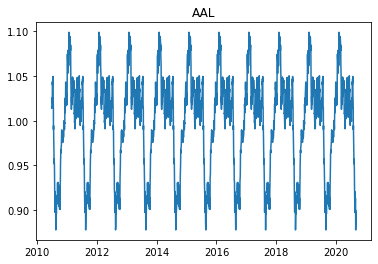

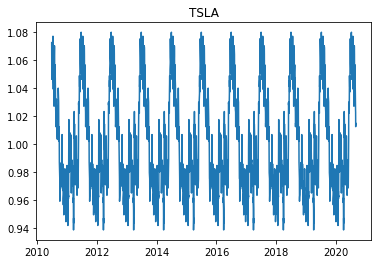

In [28]:
#Plot the seasonals for stocks
for i, j in enumerate(stock_columns):
    plt.plot(seasonals[i])
    plt.title(j)
    plt.show()

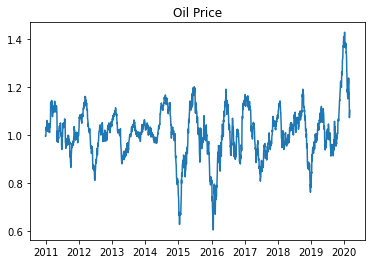

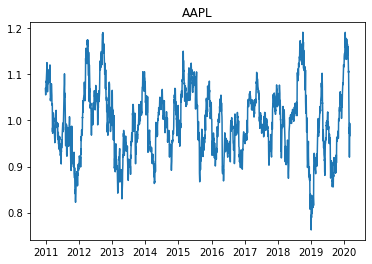

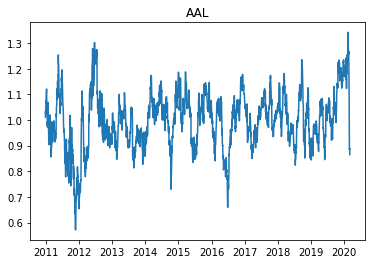

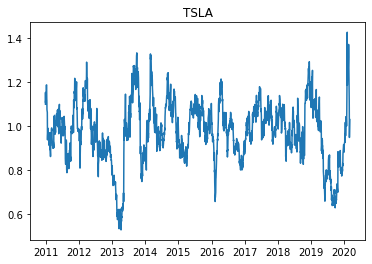

In [29]:
#Plot the residuals for each stock
for i, j in enumerate(stock_columns):
    plt.plot(residuals[i])
    plt.title(j)
    plt.show()
    continue

From the graphics, I concluded that Oil Price is very volatile, but the overall trend is to decrease.


For American Airlines, it was increasing its stock price, but recently their stock is going down as well. 


Finally, for Apple and Tesla, they have been increasing their stock value during time, and it is remarkable that Tesla increased dramatically its stock price during 2019. On the other hand, Apple increase has been more gradually than Tesla. 

Stocks more similarly regarding their stationarity and all of the stocks have similar value on their residuals as well.

# Modeling

#### Now we are in the modeling part. We are creating different X and Y arrays for each method. With method I'm referring to linear methods and sesonality methods

### Create the y and x arrays  for Regressions

In [30]:
#Divide between train and test data
#For time series, we would divide in consecutive train and test data set

In [31]:
#Reset Index to have date as categorical variables to run linear models
df2 = df.reset_index(inplace = True)

In [32]:
#Create the Date as categorical variables
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

In [33]:
#Drop the current date column
df2 = df.drop(columns = 'Date', axis = 1, inplace = True)

In [34]:
#Concat the data frame data function as categorical variable with the stock and oil prices
df2 = pd.concat([df_date, df], axis = 1)

In [35]:
#See how the data frame looks like 
df2.head()

,Year,Month,Day,Oil Price,AAPL,AAL,TSLA
0,2010,6,29,72.66,7.905947,8.051013,4.778
1,2010,6,30,72.49,7.762749,8.117004,4.766
2,2010,7,1,70.48,7.668618,8.154712,4.392
3,2010,7,2,69.63,7.621089,7.721052,3.840
4,2010,7,6,69.73,7.673245,7.617351,3.222


In [36]:
#Create our X array for the regressions
X = df2[['Year','Month', 'Day', 'Oil Price']].values

In [37]:
#Create the y arrays
y = df2.iloc[:,4:].values

In [38]:
#Dependant Variable
y_oil = df2['Oil Price']
y_aapl = df2['AAPL']
y_aal = df2['AAL']
y_tsla = df2['TSLA']

#### Divide into train and test data

In [39]:
#Define the 80% of the data as train data and 20% as test data
q3 = int(len(y)*0.8)
q1 = int(len(y) *0.2)

In [40]:
#Define train function
def train(array):
    return array[:q3]

In [41]:
#Define test
def test(array):
    return array[q3:]

In [42]:
#X train and test array
X_train = train(X)
X_test = test(X)

In [43]:
# y train and test array
y_train = train(y)
y_test = test(y)

#### Define arrays for each stock

In [44]:
#Apple Stock
y_aapl_train = [i[0] for i in y_train]
y_aapl_test = [i[0] for i in y_test]

In [45]:
# American Airlines Stock
y_aal_train = [i[1] for i in y_train]
y_aal_test = [i[1] for i in y_test]

In [46]:
#Tesla Stock
y_tsla_train = [i[2] for i in y_train]
y_tsla_test = [i[2] for i in y_test]

## Standarization

I am also doing standarization in order to compare the results between standarized and not standarized data and see which model performs the best.

#### Standarization

In [47]:
#Import the library
from sklearn.preprocessing import StandardScaler

In [48]:
#Apply the scaler on the x_train
def scaler(array):
    scaler = StandardScaler()
    return scaler.fit_transform(array)

In [49]:
# Standarization 
X_train_scaler = scaler(X_train)
X_test_scaler = scaler(X_test)

## Regressions

#### We are defining functions that do the linear model. This is to make the code reusable as soon as I want to add a new stock or group of stocks.

In [50]:
#Define a function for the train score
def reg_train_score(model,x_train, y_train):
    return model.score(x_train, y_train)

In [51]:
#Define a function for the test score
def reg_test_score(model, x_test, y_test):
    return model.score(x_test, y_test)

In [52]:
#Define the function for normal regression use the models we want to use to predict the stock prices in the future
def regression_fit(model, x_train, y_train):
    reg = model()
    return reg.fit(x_train, y_train)

In [53]:
#Define a function for Gradient Boosting Regressor
def regression_fit_gradient(model, x_train, y_train, learning_rate, max_depth, n_estimators, tol):
    reg = model(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth, tol = tol)
    return reg.fit(x_train, y_train)

In [54]:
#Define a function for the prediction
def regression_prediction(regression_fit, x_test):
    predict = regression_fit.predict(x_test)
    return predict

In [55]:
#Define a function to plot
def plot_regression(y_test, regression_prediction):
    plt.scatter(y_test, regression_prediction, color = 'black')
    x0 = min(y_test)
    x1 = max(y_test)
    y0 = min(regression_prediction)
    y1 = max(regression_prediction)
    plt.plot([x0,x1], [y0, y1], color = 'red')
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
    plt.title('Actual vs Predicted Stock Price')
    return plt.show()

In [56]:
#Define a function to create a data frame for the coefficients
def coefficients(reg):
    coefficients = pd.DataFrame()
    coefficients['Variable'] = ['Year', 'Month', 'Day', 'Oil Price']
    coefficients['Coefficients'] = reg.coef_
    return coefficients

In [57]:
#Define a function for Cross Validation
def grid_search(model, param_grid, x_train, y_train,cv = 3):
    model = model()
    model_cv = GridSearchCV(model, param_grid, cv = 3)
    model_cv.fit(x_train, y_train)
    print('Based on the Cross Validation, the best parameters were:',
          model_cv.best_params_)

### Apple 

#### Standard Regression

In [58]:
#Create the model for Apple
reg = regression_fit(LinearRegression, X_train, y_aapl_train)
#See the predictions
predict = regression_prediction(reg, X_test)

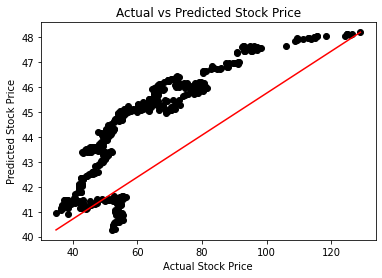

In [59]:
#Plot the results
plot_regression(y_aapl_test, predict)

In [60]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aapl_train), 
                                                                reg_test_score(reg, X_test, y_aapl_test)))

The train and the test score are 0.8684797691083016 and -0.6582859588407963 respectively


In [61]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,4.404220
1,Month,0.412601
2,Day,0.008598
3,Oil Price,0.043932


#### Standard Regression with Standarization

In [62]:
#Create the model for Apple
reg = regression_fit(LinearRegression, X_train_scaler, y_aapl_train)
#See the predictions
predict = regression_prediction(reg, X_test_scaler)

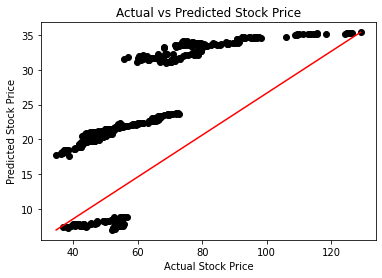

In [63]:
#Plot the results
plot_regression(y_aapl_test, predict)

In [64]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_aapl_train), 
                                                                reg_test_score(reg, X_test_scaler, y_aapl_test)))

The train and the test score are 0.8684797691083125 and -3.7048687886627842 respectively


#### Gradient Boosting Regressor

In [65]:
#Establish possible parameters to do the Grid Search
param_grid = {'learning_rate': [0.1, 1.0],
             'n_estimators': [100, 250],
             'max_depth': [3, 5],
             'tol': [0.0001, 0.01, 1]}

In [66]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train, y_aapl_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'tol': 0.0001}


In [67]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_aapl_train, learning_rate =
                        0.1, max_depth = 3, n_estimators = 100, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

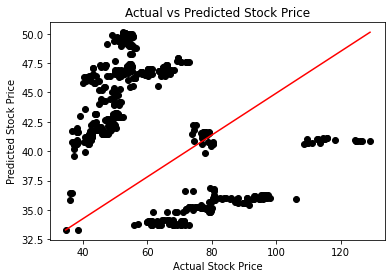

In [68]:
#Plot the results
plot_regression(y_aapl_test, reg_pred)

In [69]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aapl_train), 
                                                                reg_test_score(reg, X_test, y_aapl_test)))

The train and the test score are 0.9930574479142131 and -1.3126609564691067 respectively


#### Gradient Boosting Classifier with Standarization

In [70]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train_scaler, y_aapl_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'tol': 1}


In [71]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_aapl_train, learning_rate =
                        0.1, max_depth = 3, n_estimators = 100, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

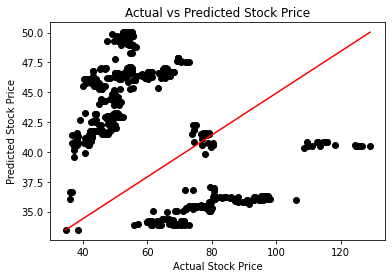

In [72]:
#Plot the results
plot_regression(y_aapl_test, reg_pred)

In [73]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_aapl_train), 
                                                                reg_test_score(reg, X_test_scaler, y_aapl_test)))

The train and the test score are -2.097607508076411 and -7.989272536510197 respectively


### American Airlines

#### Standard Regression

In [74]:
#Create the model for American Airlines
reg = regression_fit(LinearRegression, X_train, y_aal_train)
#See the predictions
predict = regression_prediction(reg, X_test)

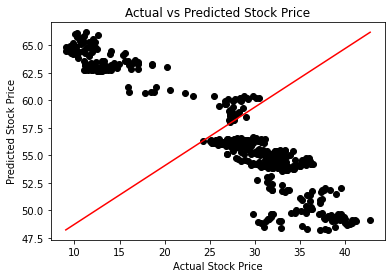

In [75]:
#Plot the results
plot_regression(y_aal_test, predict)

In [76]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aal_train), 
                                                                reg_test_score(reg, X_test, y_aal_test)))

The train and the test score are 0.8355231390268394 and -12.415163543793538 respectively


In [77]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,5.076209
1,Month,0.215497
2,Day,0.018191
3,Oil Price,-0.121225


#### Standard Regression with Standarization

In [78]:
#Create the model for American Airlines
reg = regression_fit(LinearRegression, X_train_scaler, y_aal_train)
#See the predictions
predict = regression_prediction(reg, X_test_scaler)

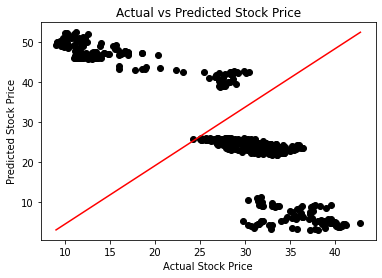

In [79]:
#Plot the results
plot_regression(y_aal_test, predict)

In [80]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_aal_train), 
                                                                reg_test_score(reg, X_test_scaler, y_aal_test)))

The train and the test score are 0.8355231390268485 and -5.468351197927753 respectively


In [81]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,12.096508
1,Month,0.732263
2,Day,0.159182
3,Oil Price,-3.390307


#### Gradient Boosting with Standarization

In [82]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train, y_aal_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 100, 'tol': 0.01}


In [83]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_aal_train, learning_rate =
                        0.1, max_depth = 5, n_estimators = 250, tol = 1)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

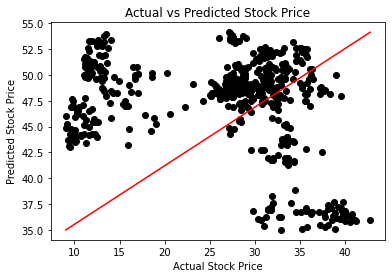

In [84]:
#Plot the results
plot_regression(y_aal_test, reg_pred)

In [85]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aal_train), 
                                                                reg_test_score(reg, X_test, y_aal_test)))

The train and the test score are 0.9989063059513702 and -5.725750209710245 respectively


#### Gradient Boosting with Standarization

In [86]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train_scaler, y_aal_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 100, 'tol': 1}


In [87]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_aapl_train, learning_rate =
                        0.1, max_depth = 5, n_estimators = 250, tol = 1)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

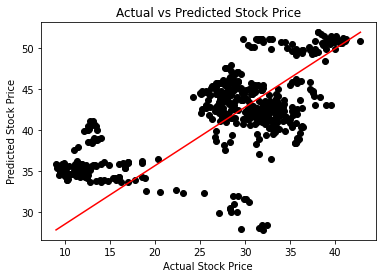

In [88]:
#Plot the results
plot_regression(y_aal_test, reg_pred)

In [89]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_aal_train), 
                                                                reg_test_score(reg, X_test, y_aal_test)))

The train and the test score are 0.5421949509852886 and -2.2271604560997726 respectively


### Tesla

#### Standard Regression

In [90]:
#Create the model for Tesla
reg = regression_fit(LinearRegression, X_train, y_tsla_train)
#See the predictions
predict = regression_prediction(reg, X_test)

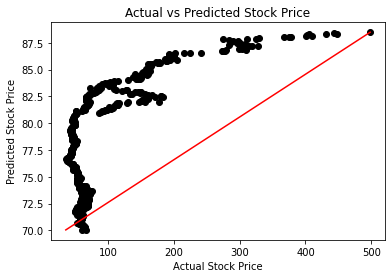

In [91]:
#Plot the results
plot_regression(y_tsla_test, predict)

In [92]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_tsla_train), 
                                                                reg_test_score(reg, X_test, y_tsla_test)))

The train and the test score are 0.8648413079589319 and 0.01674577391830767 respectively


In [93]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,8.994587
1,Month,0.938611
2,Day,0.033673
3,Oil Price,0.002201


#### Standard Regression with Standarization

In [94]:
#Create the model for Tesla
reg = regression_fit(LinearRegression, X_train_scaler, y_tsla_train)
#See the predictions
predict = regression_prediction(reg, X_test_scaler)

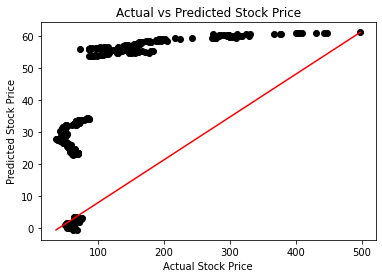

In [95]:
#Plot the results
plot_regression(y_tsla_test, predict)

In [96]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_tsla_train), 
                                                                reg_test_score(reg, X_test_scaler, y_tsla_test)))

The train and the test score are 0.8648413079589468 and -0.4168864362085117 respectively


In [97]:
#See the coefficients for the Standard Linear Regression
coefficients(reg = reg)

,Variable,Coefficients
0,Year,21.433927
1,Month,3.189422
2,Day,0.294663
3,Oil Price,0.061557


#### Gradient Boosting Classifier

In [98]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train, y_tsla_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'tol': 0.0001}


In [99]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_tsla_train, learning_rate =
                        1.0, max_depth = 3, n_estimators = 250, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

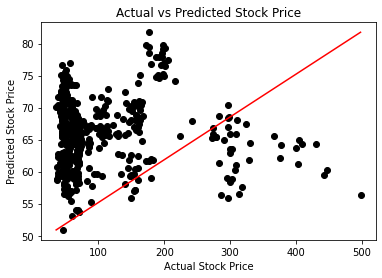

In [100]:
#Plot the results
plot_regression(y_tsla_test, reg_pred)

In [101]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train, y_tsla_train), 
                                                                reg_test_score(reg, X_test, y_tsla_test)))

The train and the test score are 0.9992235269883438 and -0.18738665206836513 respectively


#### Gradient Boosting Classifier with Standarization

In [102]:
#Use the function we previously defined
warnings.simplefilter("ignore")
grid_search(GradientBoostingRegressor, param_grid, X_train_scaler, y_tsla_train,cv = 3)

Based on the Cross Validation, the best parameters were: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'tol': 0.01}


In [103]:
#Fit the model
reg = regression_fit_gradient(GradientBoostingRegressor, X_train, y_tsla_train, learning_rate =
                        1.0, max_depth = 3, n_estimators = 250, tol = 0.0001)
#Make the predictions
reg_pred = regression_prediction(reg, X_test)

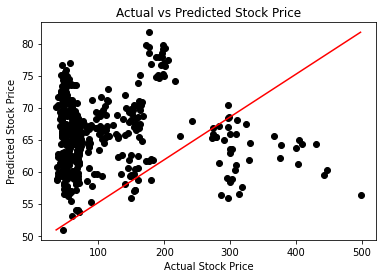

In [104]:
#Plot the results
plot_regression(y_tsla_test, reg_pred)

In [105]:
#Print the scores
print('The train and the test score are {} and {} respectively'.format(reg_train_score(reg,X_train_scaler, y_tsla_train), 
                                                                reg_test_score(reg, X_test_scaler, y_tsla_test)))

The train and the test score are -0.7142200207519287 and -1.1102003861250282 respectively


#### Insights from the linear regression

- By doing this standard regression, we can conclude that models such as Lasso or Ridge would not work well to anticipate the future stock price. It fits well the training data, but it doesn't do well on the test data. This could also be supported because the higher increases occurred after 2018. 


- We may need to rely more on the times series analysis we are making on the next steps.

## Times Series Analysis

In this step, we are making a times series analysis in order to predict the different stock prices. This is the methodology we are following:

- Check if the data is stationary by using kpss.

- If data is not stationalry, we are making them stationary using logarithms. 

- Do a Cross Validation to see the best order for the models. For the Autocorrelation plots we can imply order = (1,0,0) would be the best.

- After we are creating the SARIMAX and ARIMA model. 

In [106]:
def transform_log(y):
    return np.log(y)

### Check if the data is stationary

In [107]:
#Firstly we need to set a higher recursion limit
sys.setrecursionlimit(10000)

In [108]:
#Check if Oil is Stationary
kpss(y_oil)

(5.440463061940448,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [109]:
#Check if Apple Stock Price is stationary
kpss(y_aapl)

(7.255100268147403,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [110]:
#Check if American Airlines data is stationary
kpss(y_aal)

(4.5799140336336945,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [111]:
#Check if Tesla Stock Price is stationary
kpss(y_tsla)

(4.741163872953131,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Insights

- For all of the stocks, the data is not stationary since we got a p-value less than 0.05 for all of them. Thereore, we need to make the data stationary by using np.log

### Making Data Stationary

In [112]:
# Oil p-value
y_oil_log = transform_log(y_oil)
kpss(y_oil_log.diff().dropna())

(0.059785057821304374,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [113]:
# Apple p-value
y_aapl_log = transform_log(y_aapl)
kpss(y_aapl_log.diff().dropna())

(0.1607841495882403,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [114]:
# American Airlines p-value
y_aal_log = transform_log(y_aal)
kpss(y_aal_log.diff().dropna())

(0.3961933229944284,
 0.0787959814679188,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [115]:
# Tesla p-value
y_tsla_log = transform_log(y_tsla)
kpss(y_tsla_log.diff().dropna())

(0.18840587005251933,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Now, all the data is stationary since for all of them we have p-values higher than 0.05

## Define the X and y arrays for the stationary models

In [116]:
#Define arrays for ARIMA
# Oil Price
y_oil_train_log = y_oil_log[q1:]
y_oil_test_log = y_oil_log[:q1]

In [117]:
#Apple
y_aapl_train_log = y_aapl_log[q1:]
y_aapl_test_log = y_aapl_log[:q1]

In [118]:
#American Airlines
y_aal_train_log = y_aal_log[q1:]
y_aal_test_log = y_aal_log[:q1]

In [119]:
#Tesla
y_tsla_train_log = y_tsla_log[q1:]
y_tsla_test_log = y_tsla_log[:q1]

In [120]:
#Creation of the data frame
df_arima = pd.DataFrame(data = [y_oil_train_log, y_aapl_train_log, y_aal_train_log, y_tsla_train_log]).T

In [121]:
df_arima.head()

,Oil Price,AAPL,AAL,TSLA
511,4.572957,2.941590,2.542986,1.840232
512,4.567780,2.932294,2.573645,1.833221
513,4.572027,2.926060,2.588629,1.840867
514,4.578005,2.916869,2.577949,1.877937
515,4.596129,2.926953,2.611731,1.924249


### ARIMA Functions

In [122]:
#Model to do the type of cross validation
def arima_model_prediction_oil(model, data, order):
    mod = model(data, order = order)
    mod_fit = mod.fit()
    pred = mod_fit.predict(start = 0, end = 510)
    pred = pred.reset_index(drop = True)
    return pred

In [123]:
# Create a function that gets the scores for each order.
#We are picking the order that has the least error
def arima_validation_oil(model, y_train):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                try:
                    pred = arima_model_prediction_oil(model, y_train, order = (p,q,d))
                    error = mean_squared_error(y_oil_test_log, pred)
                    print('({}, {}, {}) : Error of: {}'.format(p, q, d, error))
                except:
                    pass

In [124]:
def arima_model_stock_pred(model, endog, order, exog = df_arima['Oil Price']):
    mod = model(endog, order = order, exog = df_arima['Oil Price'])
    mod_fit = mod.fit()
    pred = mod_fit.predict(start = 0, end = 510)
    pred = pred.reset_index(drop = True)
    return pred

In [125]:
# Create a function to do the cross validation for stocks
def arima_validation_stock(model, y_train, y_test, exog = df_arima['Oil Price']):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                try:
                    pred = arima_model_stock_pred(model, endog = y_train, order = (p,q,d), 
                                                  exog = exog)
                    error = mean_squared_error(y_test, pred)
                    print('({}, {}, {}) : Error of: {}'.format(p, q, d, error))
                except:
                    pass

In [126]:
# Create a function to forecast
def arima_oil_forecast(model, y_train, order):
    steps = 1000
    mod = model(y_train, order)
    mod_fit = mod.fit()
    forecast = mod_fit.forecast(steps = steps)[0]
    return forecast

In [127]:
def arima_plot_oil_forecast(y_train):
    steps = 1000
    df = pd.DataFrame()
    df['Time'] = [i for i in range(2560, 2560 + steps)]
    df['Forecasting'] = forecast
    df.set_index('Time', inplace = True)
    plt.plot(y_train, color = 'blue')
    plt.plot(df['Forecasting'], color = 'orange')
    plt.ylabel('Price')
    return plt.show()

In [128]:
def arima_stock_forecast(model, endog, order, forecast):
    steps = 1000
    mod = model(endog, order, exog = df_arima['Oil Price'])
    mod_fit = mod.fit()
    forecast = mod_fit.forecast(steps = steps, exog = forecast)[0]
    return forecast

In [129]:
def arima_plot_forecast(y_train, stock_forecast):
    steps = 1000
    df1 = pd.DataFrame(y_train)
    df2 = pd.DataFrame(stock_forecast, columns = df1.columns)
    df2['Time'] = [i for i in range(2559, 2559 + 1000)]
    df2.set_index('Time', inplace = True)
    df = df1.append(df2)
    plt.plot(df[df.columns], color = 'orange')
    plt.axvline(x = 2560)
    return plt.show()

### SARIMAX Functions

In [130]:
#Function to do the SARIMAX to the oil
def sarimax_model_prediction_oil(model, endog, seasonal_order, exog = None):
    model = model(endog, exog, seasonal_order)
    model = model.fit()
    pred = model.predict(start = 0, end = 510)
    pred = pred.reset_index(drop = True)
    return pred

In [131]:
# Create a function that gets the scores for each order.
#We are picking the order that has the least error
def sarimax_validation_oil(model, y_train):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                for s in s_value:
                    try:
                        pred = sarimax_model_prediction_oil(model, y_train, seasonal_order = (p, q, d, s), exog = None)
                        error = mean_squared_error(y_oil_test_log, pred)
                        sarimax_error.append(error)
                        print('({}, {}, {}, {}), error:{}'.format(p, q, d, s, error))
                    except:
                        pass

In [132]:
def sarimax_model_prediction_stock(endog, order):
    model = SARIMAX(endog, exog = df_arima['Oil Price'], seasonal_order = order)
    model = model.fit()
    pred = model.predict(start = 0, end = 510)
    pred = pred.reset_index(drop = True)
    return pred

In [133]:
# Create a function that gets the scores for each order.
#We are picking the order that has the least error
def sarimax_validation_stock(y_train, y_test):
    for p in p_value:
        for q in q_value:
            for d in d_value:
                for s in s_value:
                    try:
                        pred = sarimax_model_prediction_stock(endog = y_train,
                                                              order = (p,q,d,s))
                        error = mean_squared_error(y_test, pred)
                        print('({}, {}, {}, {}), error:{}'.format(p, q, d, s, error))
                    except:
                        pass

In [134]:
# Create a function to forecast
def sarimax_oil_forecast(model, y_train):
    steps = 1000
    mod = model(y_train, exog = None, seasonal_order = (0,1,0,1))
    mod_fit = mod.fit()
    forecast = mod_fit.forecast(steps = steps)
    return forecast

In [135]:
# Create a function to forecast
def sarimax_stock_forecast(endog, order, forecast):
    model = SARIMAX(endog, exog = df_arima['Oil Price'], seasonal_order = order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps = 1000, exog = forecast.values.reshape(-1,1))
    return forecast

In [136]:
def sarimax_plot_oil_forecast(y_train):
    plt.plot(y_oil_train_log, color = 'blue')
    plt.plot(forecast_sarimax, color = 'orange')
    plt.ylabel('Price')
    return plt.show()

In [137]:
def sarimax_plot_forecast(y_train, stock_forecast):
    steps = 1000
    df1 = pd.DataFrame(y_train)
    df2 = pd.DataFrame(stock_forecast, columns = df1.columns)
    df = df1.append(df2)
    plt.plot(df[df.columns], color = 'orange')
    plt.axvline(x = 2560)
    return plt.show()

### Plot comparison between predictions and test data

In [138]:
#Define a function to plot the predictions and the actual values
def plot_times_series(y_test, y_pred):
    plt.plot(y_test, color = 'black', label = 'Actual Price')
    plt.plot(y_pred, color = 'orange', label = 'Predicted Price')
    plt.ylabel('Price')
    plt.legend(loc = 'best')
    return plt.show()

## Oil Price

### ARIMA

In [139]:
#Set a range of values to check out the best order for ARIMA
p_value = list(range(0,3))
q_value = list(range(0,3))
d_value = list(range(0,3))
s_value = list(range(0,3))

In [140]:
#See the error of each
arima_validation_oil(ARIMA,y_oil_train_log)

(0, 0, 0) : Error of: 0.234369846613576
(0, 0, 1) : Error of: 0.06969527045434398
(1, 0, 0) : Error of: 0.03367338016496941
(1, 0, 1) : Error of: 0.03367851698228741
(1, 0, 2) : Error of: 0.033679390426587186
(2, 0, 0) : Error of: 0.033678978233868076
(2, 0, 1) : Error of: 0.03371065677357072
(2, 0, 2) : Error of: 0.03367927267021815


- Regarding the oil, we got the least error on the ARIMA order with order = (1,0,0)

In [141]:
#Run the function for order = (1,0,0)
pred = arima_model_prediction_oil(ARIMA, y_oil_train_log, order = (1,0,0))

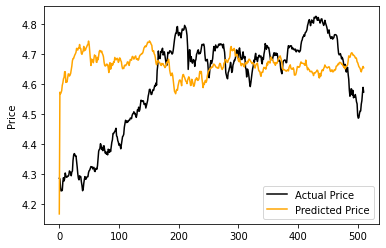

In [142]:
# Plot the prediction and the test data
plot_times_series(y_oil_test_log, pred)

In [143]:
#Do the forecast
forecast = arima_oil_forecast(ARIMA, y_oil_train_log, order = (1,0,0))

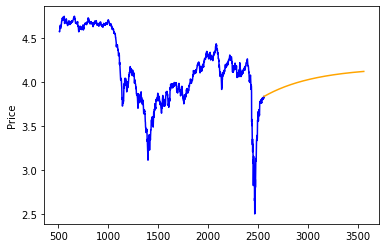

In [144]:
#Plot our expected oil forecast
arima_plot_oil_forecast(y_oil_train_log)

#### From the Oil Price, after doing the forecast, we are seeing the oil price is expecting to increase in the futre and be stable (This may not be totally true due to the previous oil behavior that is characterized to be very volatil).

### SARIMAX

In [145]:
#SARIMAX Cross Validation
sarimax_validation_oil(SARIMAX, y_oil_train_log)

In [146]:
#Doing SARIMAX seasonal_order = (0,1,0,1)
pred = sarimax_model_prediction_oil(model = SARIMAX, endog = y_oil_train_log, 
                                    seasonal_order = (1,0,0,1), exog = None)

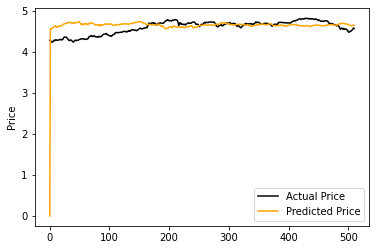

In [147]:
# Plot the prediction and the test data
plot_times_series(y_oil_test_log, pred)

In [148]:
#Do the forecast
forecast_sarimax = sarimax_oil_forecast(SARIMAX, y_oil_train_log)

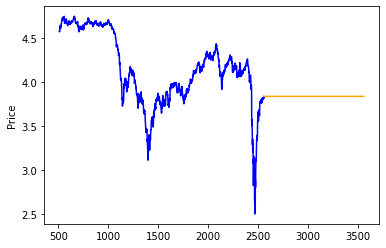

In [149]:
#Plot our expected oil forecast
sarimax_plot_oil_forecast(y_oil_train_log)

#### Sarimax on the hand is saying that the oil price would be very constant during the next months. We don't really think tht's going to hapen.

## Apple

### ARIMA

In [150]:
# Do the cross validation
arima_validation_stock(ARIMA, y_train = y_aapl_train_log, y_test = y_aapl_test_log, exog = df_arima['Oil Price'])

(0, 0, 0) : Error of: 0.4823187534231384
(0, 0, 1) : Error of: 0.3275167899190304
(0, 0, 2) : Error of: 0.2781366719542156
(1, 0, 0) : Error of: 0.20652021937748974
(2, 0, 0) : Error of: 9.419029724243234


In [151]:
#Apple Arima
pred_aapl = arima_model_stock_pred(ARIMA, endog = y_aapl_train_log, order = (1,0,0), exog = df_arima['Oil Price'])

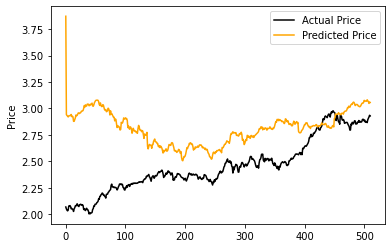

In [152]:
#Compare the predicted and the test values
plot_times_series(y_aapl_test_log, pred_aapl)

In [153]:
#Do the forecast
aapl_forecast = arima_stock_forecast(ARIMA, endog = y_aapl_train_log, order = (1,0,0), forecast = forecast)

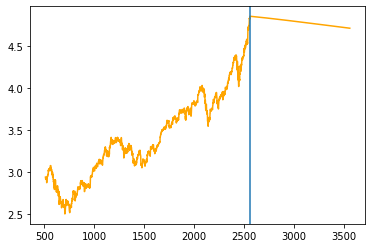

In [154]:
# Plot the forecast
arima_plot_forecast(y_aapl_train_log, aapl_forecast)

#### From this forecast, Apple trend is to have a reduction on the stock price in the future (All the data is logartmical, so it is also necessary that after making any calculus do the proper math to have it in dollars).

### SARIMAX

In [155]:
#Do the cross validation
sarimax_validation_stock(y_aapl_train_log, y_aapl_test_log)

(0, 0, 0, 0), error:0.2046033433850096
(0, 0, 0, 1), error:0.2046033433850096
(0, 0, 0, 2), error:0.2046033433850096
(0, 0, 1, 0), error:0.204518849709059
(0, 0, 1, 1), error:0.204518849709059
(0, 0, 1, 2), error:0.20460812718375937
(0, 0, 2, 0), error:0.20483629752279792
(0, 0, 2, 1), error:0.20483629752279792
(0, 0, 2, 2), error:0.20463914621459975
(0, 1, 0, 1), error:0.2046341092305495
(0, 1, 0, 2), error:0.20753949019712925
(0, 1, 1, 1), error:0.2045465971587265
(0, 1, 1, 2), error:0.2075941401040744
(0, 1, 2, 1), error:0.20455080375409565
(0, 1, 2, 2), error:0.207370804603531
(0, 2, 0, 1), error:0.2123324559543145
(0, 2, 0, 2), error:0.22328672242509492
(0, 2, 1, 1), error:0.21112931357204348
(0, 2, 1, 2), error:0.22102545012084174
(0, 2, 2, 1), error:0.21130183488010262
(0, 2, 2, 2), error:0.22177632756123122
(1, 0, 0, 0), error:0.20346847126322637
(1, 0, 0, 1), error:0.20346847126322637
(1, 0, 0, 2), error:0.20324585665873804
(1, 0, 1, 0), error:0.20457528372706385
(1, 0, 1, 1),

In [156]:
# Variable with the predictions
pred_aapl = sarimax_model_prediction_stock(y_aapl_train_log, order = (2,0,0,2))

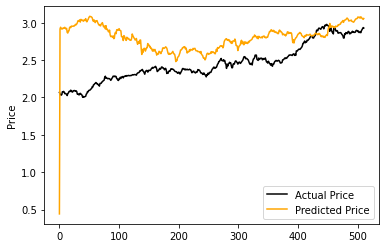

In [157]:
#Compare the predicted and the test values
plot_times_series(y_aapl_test_log, pred_aapl)

In [158]:
#Do the forecast
aapl_forecast = sarimax_stock_forecast(y_aapl_train_log, order = (2,0,0,2), forecast = forecast_sarimax)

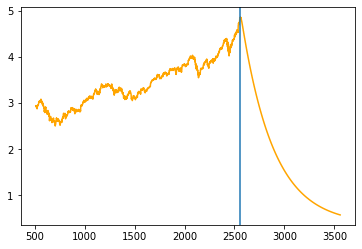

In [159]:
#Plot the forecast
sarimax_plot_forecast(y_aapl_train_log, aapl_forecast)

#### Sarimax is telling Apple's stock price is going to decrease dramatically. That's very difficult to happen. Apple is a well based company in the U.S and we hardly believe their stock would be so devaluated.

### American Airlines

In [160]:
#Do the cross validation
arima_validation_stock(ARIMA, y_aal_train_log, y_aal_test_log, df_arima['Oil Price'])

(0, 0, 0) : Error of: 1.5039229980743263
(0, 0, 1) : Error of: 1.220861796664418
(1, 0, 0) : Error of: 1.0635166742133322
(1, 0, 1) : Error of: 1.0645129233632369
(1, 0, 2) : Error of: 1.0645386663756038
(2, 0, 0) : Error of: 1.0646106051560023
(2, 0, 1) : Error of: 1.0645242825689338
(2, 0, 2) : Error of: 1.0631099258534906


In [161]:
#American Airlines Arima
pred_aal = arima_model_stock_pred(ARIMA, endog = y_aal_train_log, order = (2,0,2), exog = df_arima['Oil Price'])

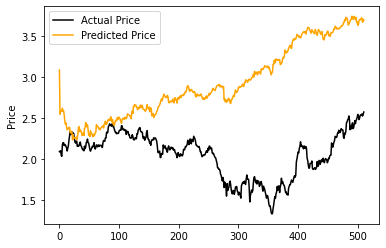

In [162]:
#Plot the test and the predicted values
plot_times_series(y_aal_test_log, pred_aal)

In [163]:
#Do the forecast
aal_forecast = arima_stock_forecast(ARIMA, endog = y_aal_train_log, order = (2,0,2), forecast = forecast)

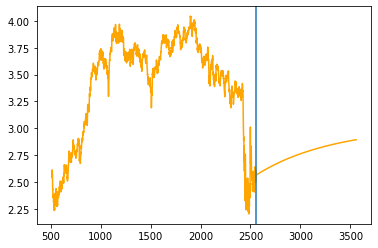

In [164]:
#Plot the Forecast
arima_plot_forecast(y_aal_train_log, aal_forecast)

#### On American Airlines, we ar eseeing the stock may appreciate in the future but not going back to the previous stock price for a while.

### Sarimax

In [165]:
# Do the cross validation
sarimax_validation_stock(y_aal_train_log, y_aal_test_log)

(0, 0, 0, 0), error:1.0654066850433048
(0, 0, 0, 1), error:1.0654066850433048
(0, 0, 0, 2), error:1.0654066850433048
(0, 0, 1, 0), error:1.0657215989449291
(0, 0, 1, 1), error:1.0657215989449291
(0, 0, 1, 2), error:1.065237531251611
(0, 0, 2, 0), error:1.0656520602987605
(0, 0, 2, 1), error:1.0656520602987605
(0, 0, 2, 2), error:1.06012158933281
(0, 1, 0, 1), error:1.0666156030738527
(0, 1, 0, 2), error:1.0745360198098979
(0, 1, 1, 1), error:1.066245511423204
(0, 1, 1, 2), error:1.069550852738188
(0, 1, 2, 1), error:1.0662233530970573
(0, 1, 2, 2), error:1.0693049084361979
(0, 2, 0, 1), error:1.077074221100723
(0, 2, 0, 2), error:1.0946734133058234
(0, 2, 1, 1), error:1.0722862140841605
(0, 2, 1, 2), error:1.08629666685459
(0, 2, 2, 1), error:1.0725002644553983
(0, 2, 2, 2), error:1.0788313226097674
(1, 0, 0, 0), error:1.071573903811025
(1, 0, 0, 1), error:1.071573903811025
(1, 0, 0, 2), error:1.0749121711095873
(1, 0, 1, 0), error:1.066036446936477
(1, 0, 1, 1), error:1.06603644693647

In [166]:
# Variable with the predictions
pred_aal = sarimax_model_prediction_stock(y_aal_train_log, order = (2,0,0,2))

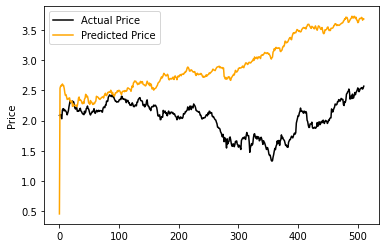

In [167]:
#Compare the predicted and the test values
plot_times_series(y_aal_test_log, pred_aal)

In [168]:
#Do the forecast
aal_forecast = sarimax_stock_forecast(y_aal_train_log, order = (2,0,0,2), forecast = forecast_sarimax)

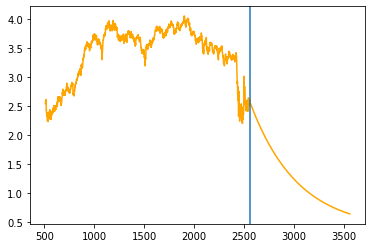

In [169]:
#Plot the forecast
sarimax_plot_forecast(y_aal_train_log, aal_forecast)

##### On the other hand, Sarimax is telling us that the stock price is going to depreciate as well. That may happen because of the current events happening in the world (coronavirus) that have the world on a big level of uncertainty (specially airlines) because of the travel restrictions.

### Tesla

In [170]:
#Do the cross validation
arima_validation_stock(ARIMA, y_tsla_train_log, y_tsla_test_log, df_arima['Oil Price'])

(0, 0, 0) : Error of: 2.374086538878046
(0, 0, 1) : Error of: 1.9640170442351148
(1, 0, 0) : Error of: 1.867903497106281
(1, 0, 1) : Error of: 1.8680076438220952
(1, 0, 2) : Error of: 1.868270027312794
(2, 0, 0) : Error of: 1.8680155092699946
(2, 0, 1) : Error of: 1.874006245122852


In [171]:
#Tesla Arima
pred_tsla = arima_model_stock_pred(ARIMA, endog = y_tsla_train_log, order = (1,0,0), exog = df_arima['Oil Price'])

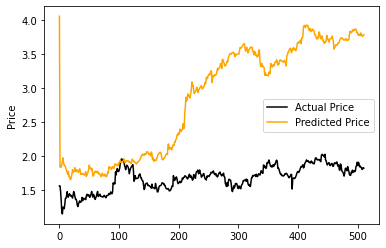

In [172]:
# Compare the test datasets
plot_times_series(y_tsla_test_log, pred_tsla)

In [173]:
#Do the forecast
tsla_forecast = arima_stock_forecast(ARIMA, endog = y_tsla_train_log, order = (1,0,0), forecast = forecast)

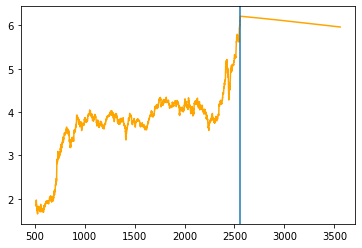

In [174]:
#Plot the Forecast
arima_plot_forecast(y_tsla_train_log, tsla_forecast)

#### Arima is also telling the tesla stock price is going to reduce, though not dramatically. It would be very moderate. 

### Sarimax

In [175]:
# Do the validation
sarimax_validation_stock(y_tsla_train_log, y_tsla_test_log)

(0, 0, 0, 0), error:1.8563560594195279
(0, 0, 0, 1), error:1.8563560594195279
(0, 0, 0, 2), error:1.8563560594195279
(0, 0, 1, 0), error:1.8564750159757097
(0, 0, 1, 1), error:1.8564750159757097
(0, 0, 1, 2), error:1.8566299262755432
(0, 0, 2, 0), error:1.8567171344473565
(0, 0, 2, 1), error:1.8567171344473565
(0, 0, 2, 2), error:1.8564057248734347
(0, 1, 0, 1), error:1.8567521529006148
(0, 1, 0, 2), error:1.858005074935472
(0, 1, 1, 1), error:1.856755443310643
(0, 1, 1, 2), error:1.8635008676855738
(0, 1, 2, 1), error:1.8639863644721146
(0, 1, 2, 2), error:1.8645734597352344
(0, 2, 0, 1), error:1.8685229700934152
(0, 2, 0, 2), error:1.8730804780518224
(0, 2, 1, 1), error:1.8682818743300824
(0, 2, 1, 2), error:1.869577041764846
(0, 2, 2, 1), error:1.8682890033614148
(0, 2, 2, 2), error:1.87771600144175
(1, 0, 0, 0), error:1.868853084748664
(1, 0, 0, 1), error:1.868853084748664
(1, 0, 0, 2), error:1.8678374209276993
(1, 0, 1, 0), error:1.860021650041814
(1, 0, 1, 1), error:1.86002165004

In [176]:
# Create the variable with the predictions
pred_tsla = sarimax_model_prediction_stock(y_tsla_train_log, order = (0,0,0,0))

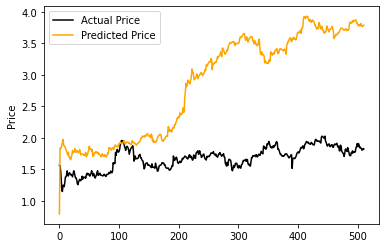

In [177]:
#Compare the predicted and the test values
plot_times_series(y_tsla_test_log, pred_tsla)

In [178]:
#Do the forecast
tsla_forecast = sarimax_stock_forecast(y_tsla_train_log, order = (0,0,0,0), forecast = forecast_sarimax)

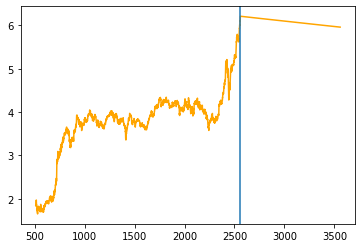

In [179]:
#Plot the forecast
sarimax_plot_forecast(y_tsla_train_log, tsla_forecast)

#### Sarimax is saying the same than Tesla


### Insights

- There is not a better model between Arima o Sarimax. The model I need to choose depends on how the model performs comparing it with the behavior of the stock. It is important to mention that since this is a model, it may go wrong with the predictions.


- For each stock, we are analyzing what may happen in the future

#### Apple 

- For Apple. both models are saying it will occurr a depreciation in Apple's stock price. We hardly believe the depreciation would be very pronounced since Apple is a well based company as mentioned before. Nevertheless, a depreciation may occur due to the events, but it is going to be very slights and the stock would trend to have a stable price. 

#### American Airlines

- This a very interesting one since it is a company highly affected because of covid. The American Airlines stock price has fell down on the last months. However, it is safe to assume in the future the stock price may increase again because the world would be recover from covid and additionally, the normal flights will return to normality.

#### Tesla

- This is maybe the most difficult stock to analyze because of the company, but not regarding what the Arima and Sarimax forecast says. It has hugely increasing their stock price on the last months, but it is also safe to mention that the models says they have reached the price which the stock behavior is not longer that volatile. 

### Recommendations

- If you don't want unexpected behavior, according to the Arima models, all the stocks are safe investments, and American Airlines will trend to increase stock price

- It is still important to mention the high influence oil prices have on the stocks behavior. According to our models, just American Airlines may increase the stock price because it moves along the oil price (this is also supported by the correlation matrix).

- If oil price continues going down, it would be a better option to invest in Tesla or Apple rather than American airlines because of the close relation with the oil price and the american airlines stock price.